In [61]:
import os
import glob
import spacy
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from collections import Counter

# turn off depreciation warnings and future warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [62]:
# Author: Zhile Xu
# UUN: s2500393

In [63]:
# load spacy model
nlp = spacy.load("en_core_web_lg")

def load_data(base_dir):
    data = []
    labels = []
    
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                
    return data, labels

In [64]:
# Load training data
train_data, train_labels = load_data('data/train')

## Preprocess the Data

In [65]:
# delete irrelevant text
def remove_irrelevant_text(data):
    new_data = []
    for text in data:
        new_data.append(text.split("What I've decided and why")[0])
    return new_data


# calutate the occurence of "What I've decided and why" in the text
def count_irrelevant_text(data):
    count = 0
    for text in data:
        if "What I've decided and why" in text:
            count += 1
    return count

count_pre = count_irrelevant_text(train_data)
print("The number of irrelevant text is: ", count_pre)
# print the number of documents in the training data
print("The number of documents in the training data is: ", len(train_data))

# remove irrelevant text
train_data = remove_irrelevant_text(train_data)
count_after = count_irrelevant_text(train_data)
print("The number of irrelevant text after removing is: ", count_after)

# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
docs = preprocess_texts(train_data)

# separate positive and negative documents
positive_docs = [doc for doc, label in zip(docs, train_labels) if label == 1]
negative_docs = [doc for doc, label in zip(docs, train_labels) if label == 0]

# function to remove stopwords and punctuation
def remove_stopwords_punctuation(doc):
    # remove stopwords and punctuation
    doc = [token for token in doc if not token.is_stop and not token.is_punct]
    # remove "\n", "Mr", "Mrs", "Miss" and "Ms"
    doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
    # remove single characters
    doc = [token for token in doc if len(token.text) > 1]
    return doc


cleaned_docs = [remove_stopwords_punctuation(doc) for doc in docs]
positive_cleaned_docs = [remove_stopwords_punctuation(doc) for doc in positive_docs]
negative_cleaned_docs = [remove_stopwords_punctuation(doc) for doc in negative_docs]

##  Lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# lowercase and lemmatise the tokens
lemmatised_positive_docs = lowercase_and_lemmatise(positive_cleaned_docs)
lemmatised_negative_docs = lowercase_and_lemmatise(negative_cleaned_docs)

The number of irrelevant text is:  445
The number of documents in the training data is:  445
The number of irrelevant text after removing is:  0


## Compute the Most Common N-grams

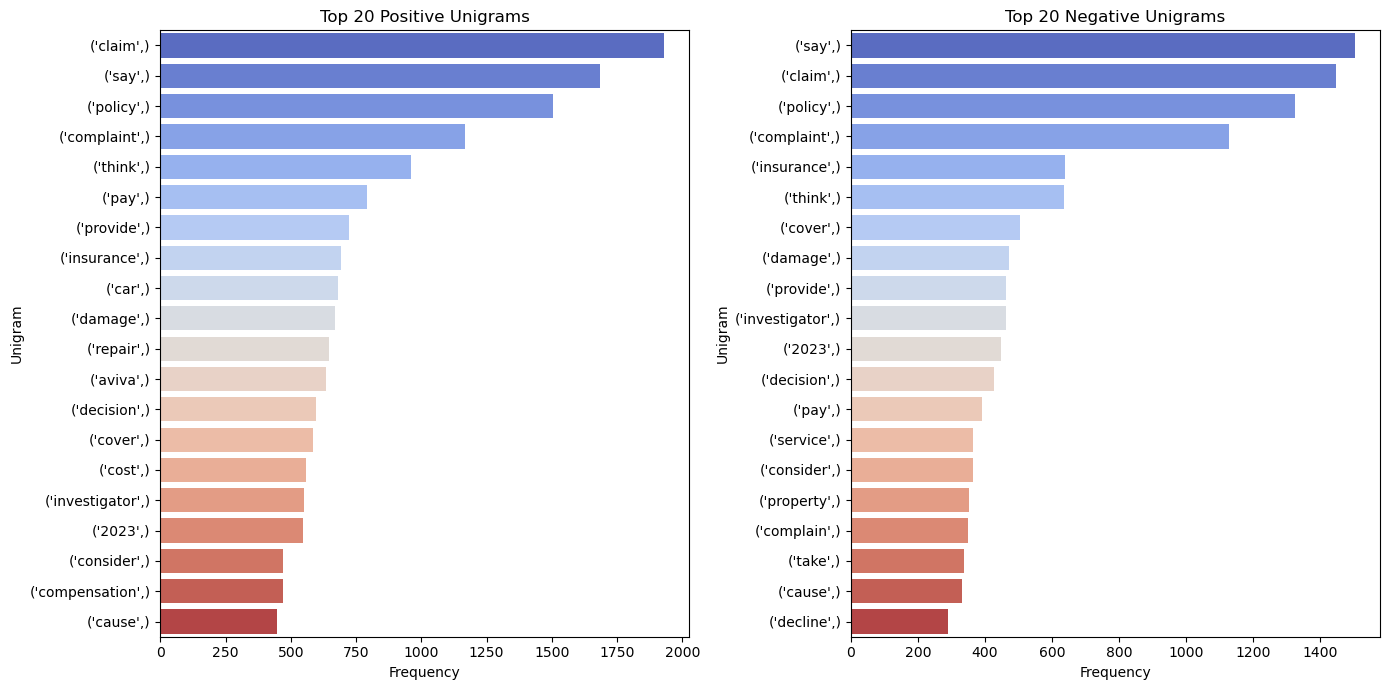

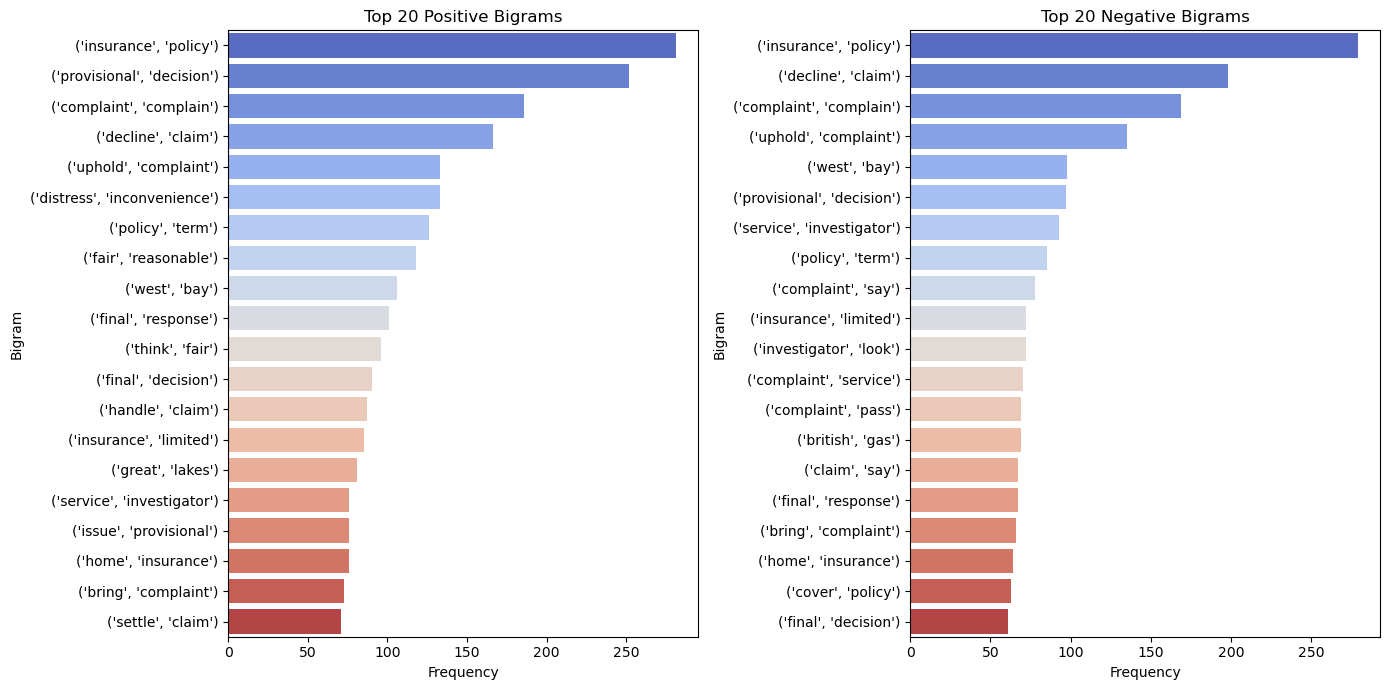

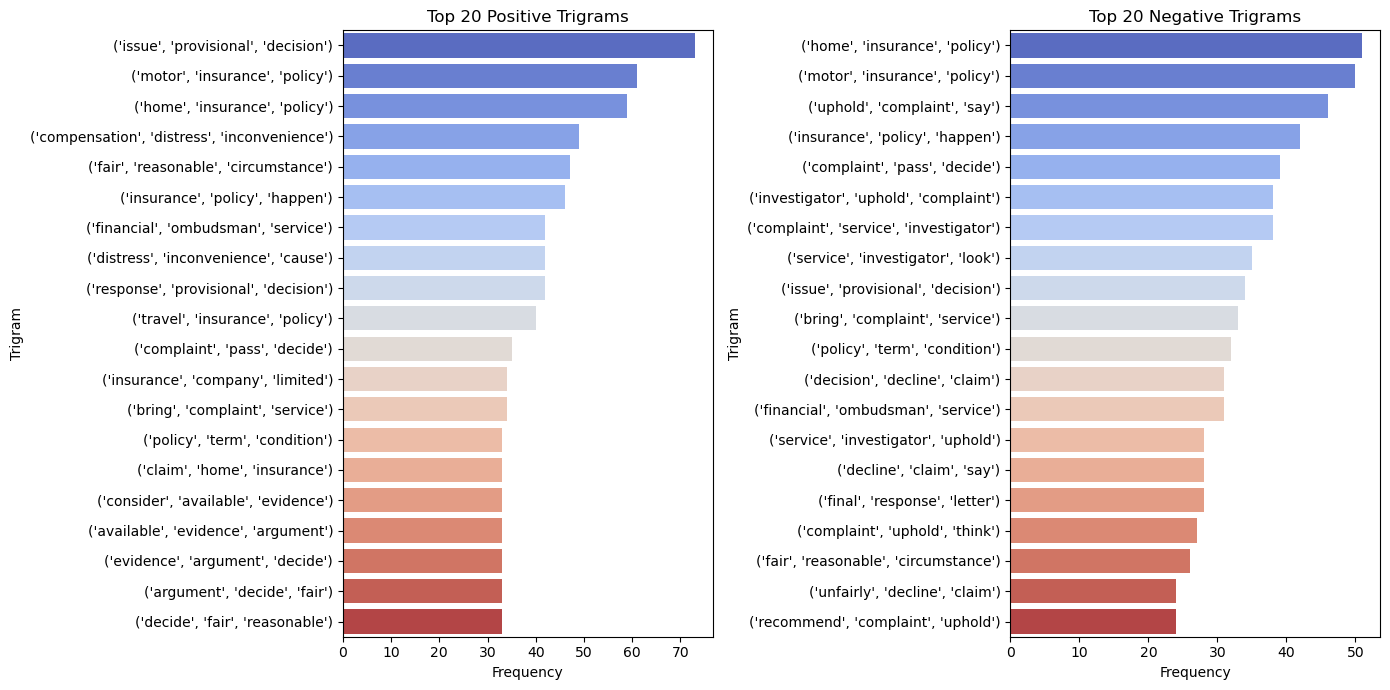

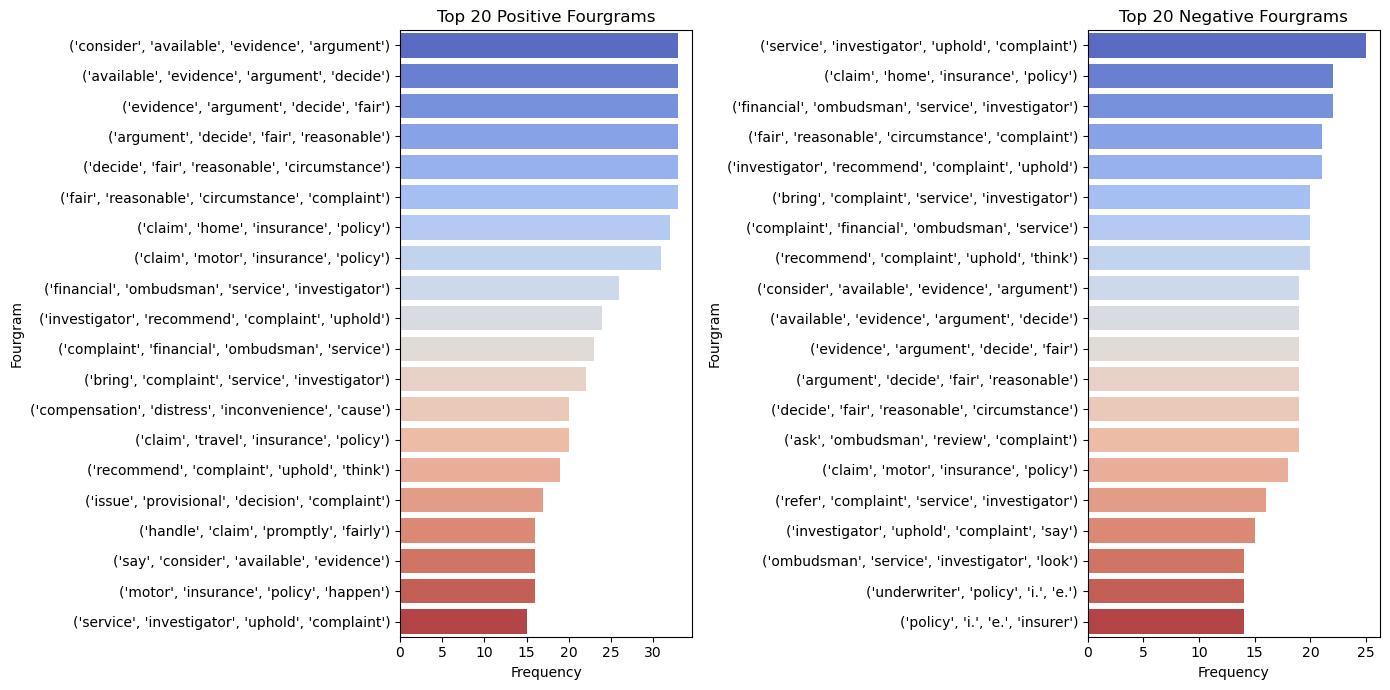

In [66]:
# What are the most common tokens, bigrams, trigrams and fourgrams?
from nltk.util import ngrams
# function to extract n-grams
def extract_ngrams(docs, n):
    ngram_counts = Counter()
    for doc in docs:
        ngram_counts.update(ngrams(doc, n))
    return ngram_counts

# extract n-grams for positive and negative documents
positive_unigrams = extract_ngrams(lemmatised_positive_docs, 1)
negative_unigrams = extract_ngrams(lemmatised_negative_docs, 1)
positive_bigrams = extract_ngrams(lemmatised_positive_docs, 2)
negative_bigrams = extract_ngrams(lemmatised_negative_docs, 2)
positive_trigrams = extract_ngrams(lemmatised_positive_docs, 3)
negative_trigrams = extract_ngrams(lemmatised_negative_docs, 3)
positive_fourgrams = extract_ngrams(lemmatised_positive_docs, 4)
negative_fourgrams = extract_ngrams(lemmatised_negative_docs, 4)

# function to plot n-grams

def plot_ngrams(positive_ngrams, negative_ngrams, ngram_name, num_ngrams=20):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # positive n-grams
    positive_ngram_df = pd.DataFrame(positive_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    # switch axes for better readability
    sns.barplot(x='Frequency', y=ngram_name, data=positive_ngram_df, ax=axs[0], palette='coolwarm')
    axs[0].set_title(f'Top {num_ngrams} Positive {ngram_name}s')
    
    # negative n-grams
    negative_ngram_df = pd.DataFrame(negative_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    sns.barplot(x='Frequency', y=ngram_name, data=negative_ngram_df, ax=axs[1], palette='coolwarm')
    axs[1].set_title(f'Top {num_ngrams} Negative {ngram_name}s')

    plt.tight_layout()

# plot unigrams
plot_ngrams(positive_unigrams, negative_unigrams, 'Unigram')

# plot bigrams
plot_ngrams(positive_bigrams, negative_bigrams, 'Bigram')

# plot trigrams
plot_ngrams(positive_trigrams, negative_trigrams, 'Trigram')

# plot fourgrams
plot_ngrams(positive_fourgrams, negative_fourgrams, 'Fourgram')


## Topic Modelling

In [67]:
# Build a Topic Model
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def build_topic_model(docs):
    # create a dictionary
    dictionary = Dictionary(docs)

    # filter out tokens that appear in less than 5 documents or more than 50% of the documents
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    # train an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, iterations=500,
                          num_topics=5, passes=50, random_state=123)

    # print the topics
    for topic_id in range(lda_model.num_topics):
        print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

    return lda_model, corpus, dictionary


In [68]:
# call the function on the whole dataset
print("Topic model for the whole dataset")
pyLDAvis.gensim.prepare(*build_topic_model(lemmatised_positive_docs + lemmatised_negative_docs))

Topic model for the whole dataset
Topic 0: 0.015*"vitality" + 0.012*"decline" + 0.010*"axa" + 0.010*"condition" + 0.010*"evidence" + 0.009*"term" + 0.008*"2022" + 0.008*"medical" + 0.008*"work" + 0.007*"treatment"
Topic 1: 0.012*"ipa" + 0.010*"west" + 0.010*"bay" + 0.009*"term" + 0.009*"medical" + 0.009*"travel" + 0.009*"information" + 0.009*"cancel" + 0.007*"cost" + 0.007*"decline"
Topic 2: 0.037*"damage" + 0.030*"car" + 0.028*"repair" + 0.018*"vehicle" + 0.018*"aviva" + 0.014*"ageas" + 0.012*"advantage" + 0.011*"report" + 0.010*"repairer" + 0.009*"evidence"
Topic 3: 0.026*"property" + 0.020*"damage" + 0.017*"aviva" + 0.015*"repair" + 0.013*"work" + 0.010*"contractor" + 0.009*"rsa" + 0.009*"cost" + 0.008*"accredited" + 0.008*"water"
Topic 4: 0.024*"car" + 0.016*"esure" + 0.014*"admiral" + 0.011*"premium" + 0.011*"offer" + 0.010*"cost" + 0.008*"payment" + 0.007*"insurer" + 0.007*"party" + 0.007*"fair"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.055879  0.091356       1        1  28.581535
4      0.009059 -0.120531       2        1  22.178180
1     -0.104498 -0.026246       3        1  21.302654
0     -0.104881  0.059203       4        1  14.233585
2      0.144442 -0.003782       5        1  13.704046, topic_info=          Term         Freq        Total Category  logprob  loglift
284     damage  1122.000000  1122.000000  Default  30.0000  30.0000
78         car   926.000000   926.000000  Default  29.0000  29.0000
459   property   748.000000   748.000000  Default  28.0000  28.0000
44      repair   902.000000   902.000000  Default  27.0000  27.0000
966      esure   360.000000   360.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
117       find    56.901701   283.093341   Topic5  -5.4687   0.3830
508       view    53.561328   219.832313   Topic5  -5.5292   0.5754
281  condition    60.126109   382.379580   Topic5  -5.4136   0.1375
118     follow    54.396207   342.243966   Topic5  -5.5138   0.1482
115      final    53.741917   366.918031   Topic5  -5.5259   0.0665

[355 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
762       2  0.908455      00
762       5  0.087562      00
350       1  0.355227    2022
350       2  0.086116    2022
350       3  0.243276    2022
...     ...       ...     ...
258       2  0.045395    work
258       3  0.003632    work
258       4  0.192475    work
258       5  0.081711    work
1108      5  0.992496  zurich

[733 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3])

In [69]:
# call the function on the positive documents
print("Topic model for the positive documents")
pyLDAvis.gensim.prepare(*build_topic_model(lemmatised_positive_docs))

Topic model for the positive documents
Topic 0: 0.015*"admiral" + 0.014*"axa" + 0.012*"decline" + 0.012*"term" + 0.009*"condition" + 0.009*"information" + 0.008*"evidence" + 0.008*"travel" + 0.007*"medical" + 0.007*"reasonable"
Topic 1: 0.056*"car" + 0.027*"repair" + 0.023*"vehicle" + 0.011*"repairer" + 0.011*"west" + 0.010*"bay" + 0.010*"hire" + 0.009*"value" + 0.009*"aviva" + 0.009*"replacement"
Topic 2: 0.024*"uki" + 0.021*"advantage" + 0.018*"esure" + 0.011*"premium" + 0.009*"car" + 0.009*"cancel" + 0.008*"reasonable" + 0.008*"delay" + 0.008*"receive" + 0.007*"cancellation"
Topic 3: 0.039*"rsa" + 0.028*"ipa" + 0.026*"property" + 0.016*"sink" + 0.015*"medical" + 0.012*"subsidence" + 0.011*"loss" + 0.010*"carry" + 0.009*"repair" + 0.008*"evidence"
Topic 4: 0.035*"aviva" + 0.019*"repair" + 0.018*"work" + 0.016*"property" + 0.012*"water" + 0.012*"contractor" + 0.011*"ageas" + 0.011*"report" + 0.010*"item" + 0.010*"home"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.015733  0.038254       1        1  28.977683
0      0.044491 -0.093085       2        1  26.567743
1     -0.142719  0.083836       3        1  19.344999
2     -0.056134 -0.095663       4        1  19.192610
3      0.170095  0.066658       5        1   5.916965, topic_info=              Term        Freq       Total Category  logprob  loglift
74             car  664.000000  664.000000  Default  30.0000  30.0000
889          aviva  628.000000  628.000000  Default  29.0000  29.0000
422       property  392.000000  392.000000  Default  28.0000  28.0000
1134           uki  238.000000  238.000000  Default  27.0000  27.0000
235        vehicle  242.000000  242.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
624        section   13.244801   62.117358   Topic5  -5.4511   1.2819
260      condition   14.946118  198.907764   Topic5  -5.3303   0.2390
506         handle   14.255473  129.105488   Topic5  -5.3776   0.6239
79    circumstance   14.563076  171.723955   Topic5  -5.3562   0.3599
128         likely   14.176974  130.783034   Topic5  -5.3831   0.6054

[327 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
694       1  0.014043      00
694       3  0.968967      00
1052      1  0.048305    2019
1052      3  0.048305    2019
1052      4  0.338135    2019
...     ...       ...     ...
237       2  0.133922    work
237       3  0.097866    work
237       4  0.048933    work
237       5  0.025754    work
969       3  0.986507  zurich

[715 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4])

In [70]:
# call the function on the negative documents
print("Topic model for the negative documents")
pyLDAvis.gensim.prepare(*build_topic_model(lemmatised_negative_docs))

Topic model for the negative documents
Topic 0: 0.023*"vitality" + 0.018*"medical" + 0.016*"decline" + 0.013*"term" + 0.013*"condition" + 0.011*"evidence" + 0.010*"work" + 0.009*"treatment" + 0.008*"note" + 0.007*"2022"
Topic 1: 0.031*"admiral" + 0.029*"rsa" + 0.021*"bay" + 0.021*"west" + 0.016*"repair" + 0.011*"property" + 0.011*"door" + 0.009*"delay" + 0.008*"home" + 0.008*"loss"
Topic 2: 0.017*"car" + 0.011*"esure" + 0.010*"lv" + 0.010*"cost" + 0.009*"premium" + 0.008*"information" + 0.008*"repair" + 0.008*"contact" + 0.007*"insurer" + 0.007*"offer"
Topic 3: 0.048*"damage" + 0.026*"property" + 0.022*"cause" + 0.018*"ipa" + 0.016*"axa" + 0.014*"water" + 0.012*"decline" + 0.011*"aviva" + 0.011*"evidence" + 0.011*"report"
Topic 4: 0.025*"cost" + 0.023*"boiler" + 0.016*"leak" + 0.014*"october" + 0.013*"aviva" + 0.013*"legal" + 0.012*"2022" + 0.012*"amtrust" + 0.011*"solicitor" + 0.011*"tell"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.020938 -0.046861       1        1  38.332819
3     -0.086207  0.115452       2        1  20.456878
0     -0.070401 -0.145240       3        1  19.997338
1     -0.036763  0.059790       4        1  11.204159
4      0.172433  0.016858       5        1  10.008806, topic_info=         Term        Freq       Total Category  logprob  loglift
201    damage  458.000000  458.000000  Default  30.0000  30.0000
340   admiral  138.000000  138.000000  Default  29.0000  29.0000
408  vitality  181.000000  181.000000  Default  28.0000  28.0000
54       cost  272.000000  272.000000  Default  27.0000  27.0000
582       rsa  127.000000  127.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
35      cause   36.972446  321.018936   Topic5  -4.6675   0.1404
102     issue   27.689535  254.430636   Topic5  -4.9566   0.0837
357     offer   26.897856  224.398186   Topic5  -4.9856   0.1803
196    accept   25.990775  206.161384   Topic5  -5.0199   0.2308
336      work   25.478109  161.211071   Topic5  -5.0398   0.4568

[330 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
695       1  0.919484    00
695       4  0.048394    00
595       1  0.257288    15
595       3  0.085763    15
595       5  0.600339    15
...     ...       ...   ...
411       1  0.478842  year
411       2  0.057175  year
411       3  0.321611  year
411       4  0.042881  year
411       5  0.100057  year

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

## Name Entity Recognition

In [71]:
# implement the named entity recognition
def extract_named_entities(docs):
    named_entities = []
    for doc in docs:
        named_entities.extend([ent.text for ent in doc.ents])
    return named_entities

# extract named entities
named_entities = extract_named_entities(docs)

# print the categories of named entities
named_entity_categories = set([ent.label_ for ent in nlp(' '.join(named_entities)).ents])
print(named_entity_categories)
# {'NORP', 'LOC', 'DATE', 'GPE', 'EVENT', 'PRODUCT', 'LAW', 'PERSON', 
# 'PERCENT', 'TIME', 'WORK_OF_ART', 'CARDINAL', 'ORDINAL', 'ORG', 
# 'FAC', 'MONEY', 'LANGUAGE', 'QUANTITY'}

# extract named entities for positive and negative documents
positive_named_entities = extract_named_entities(positive_docs)
negative_named_entities = extract_named_entities(negative_docs)


{'NORP', 'LOC', 'DATE', 'GPE', 'EVENT', 'PRODUCT', 'LAW', 'PERSON', 'PERCENT', 'TIME', 'WORK_OF_ART', 'CARDINAL', 'ORDINAL', 'ORG', 'FAC', 'MONEY', 'LANGUAGE', 'QUANTITY'}


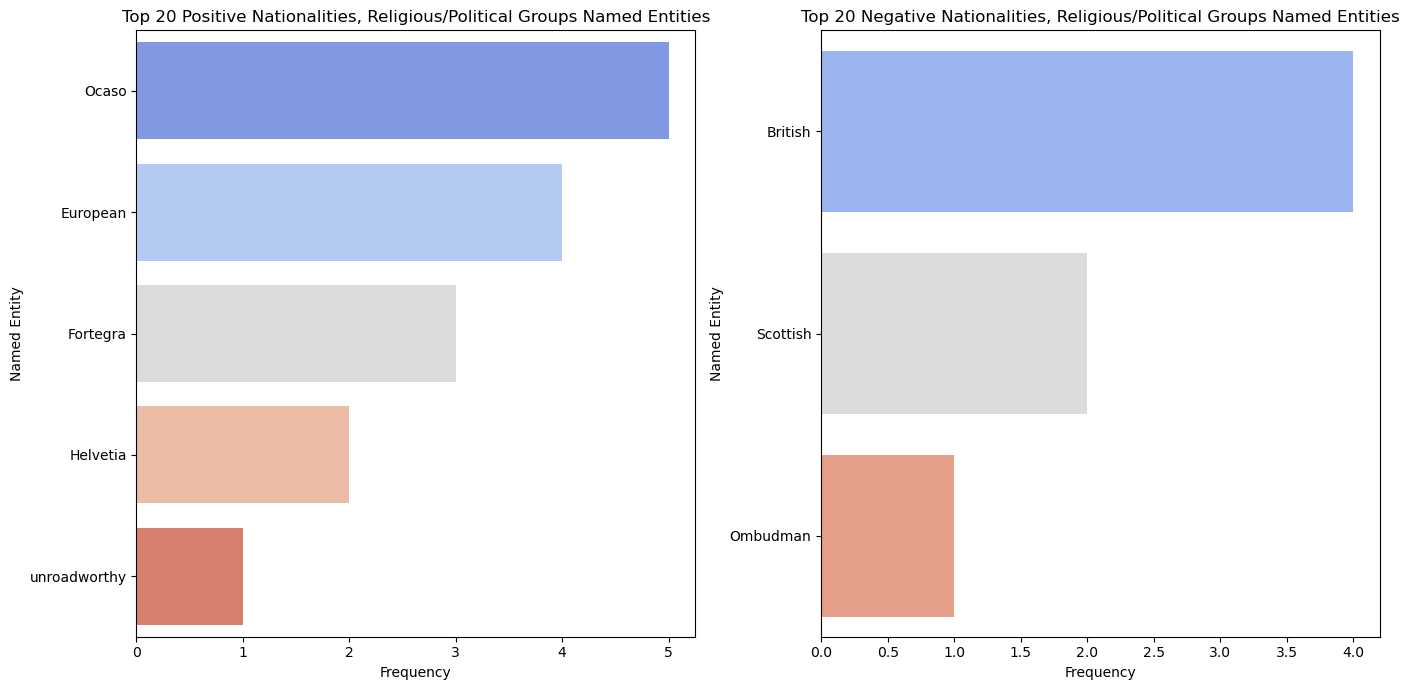

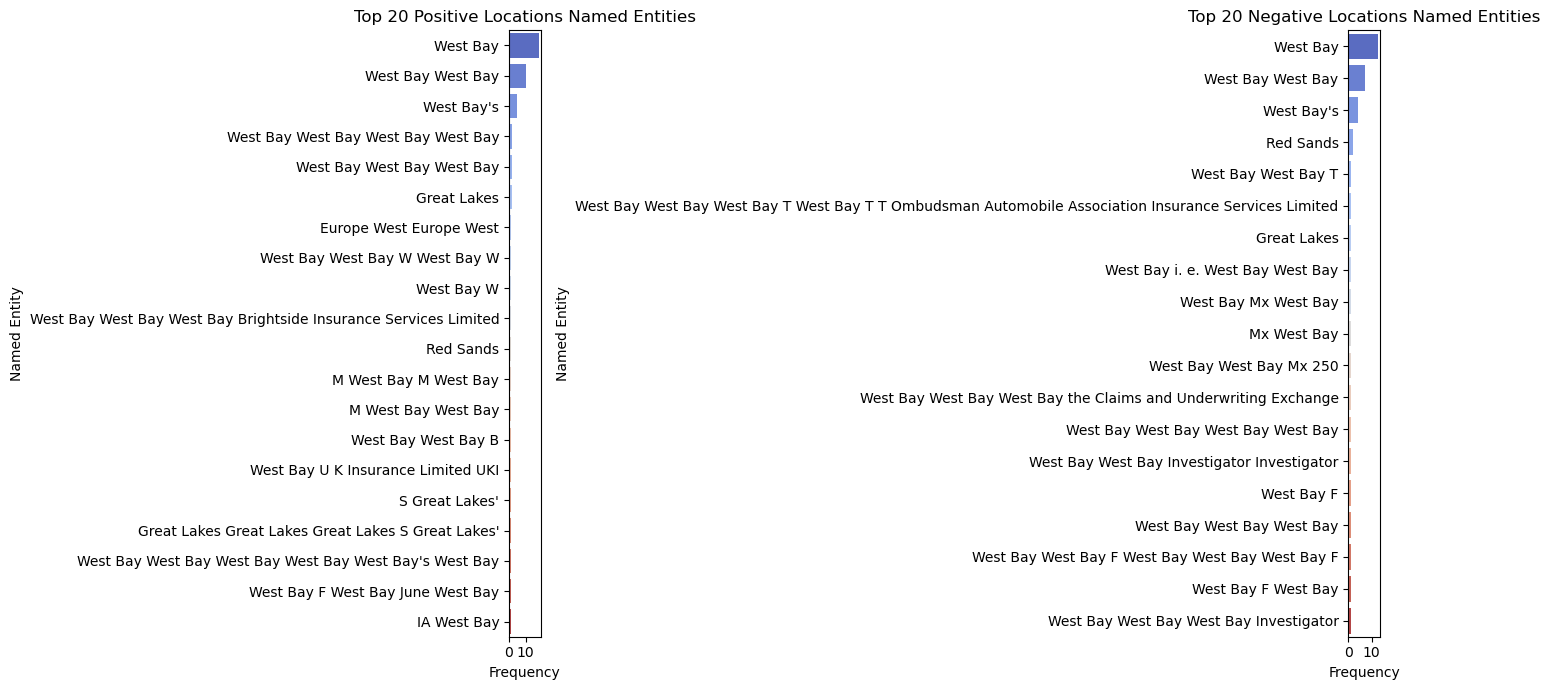

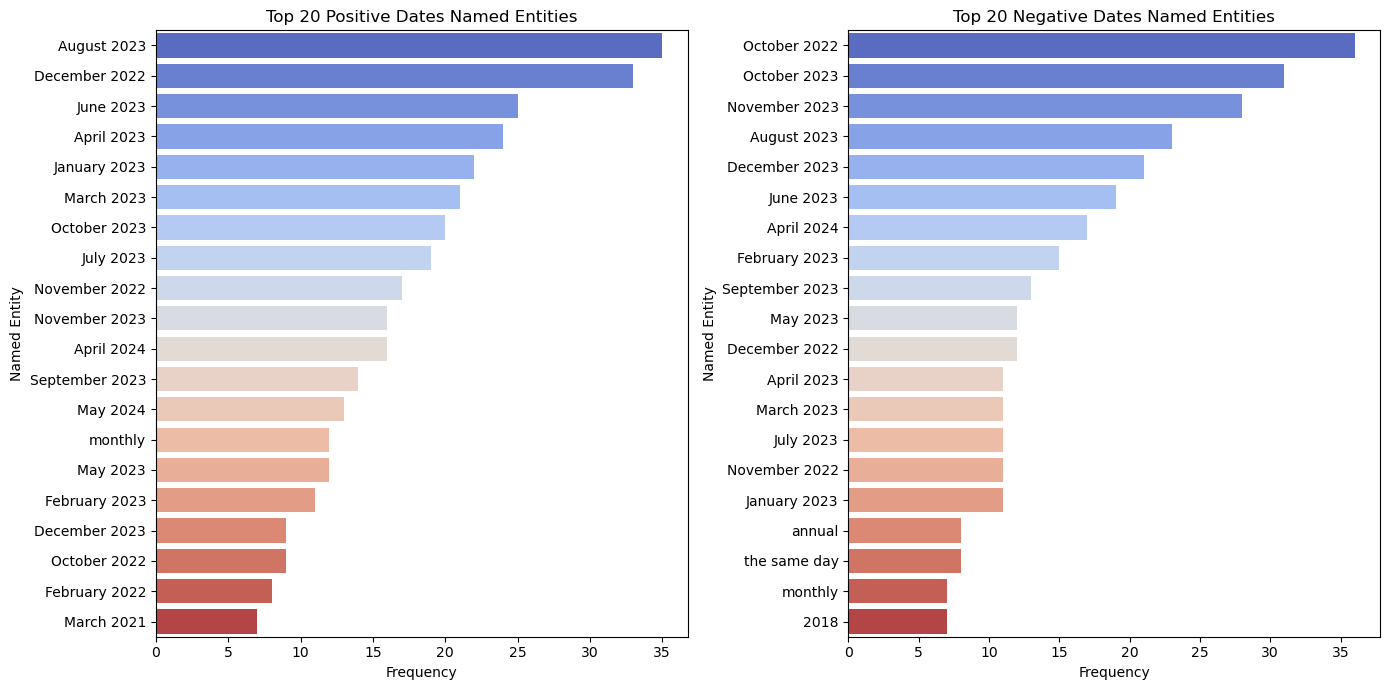

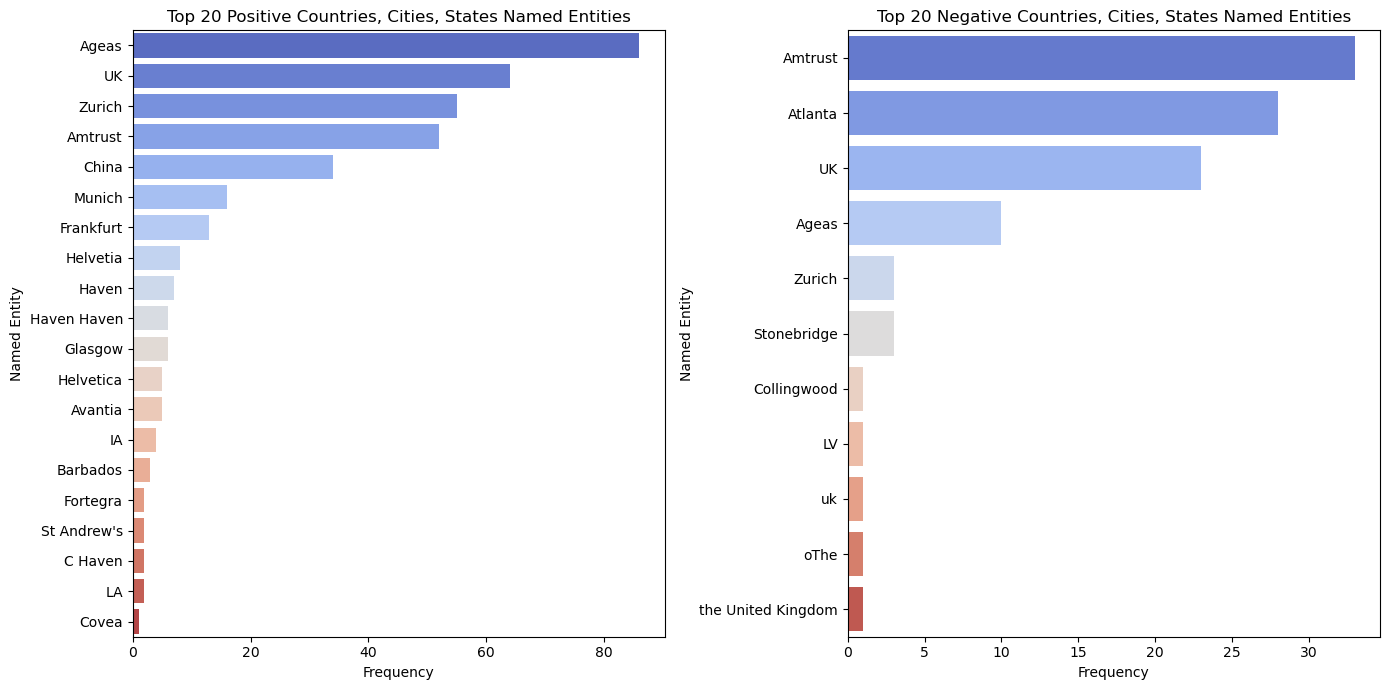

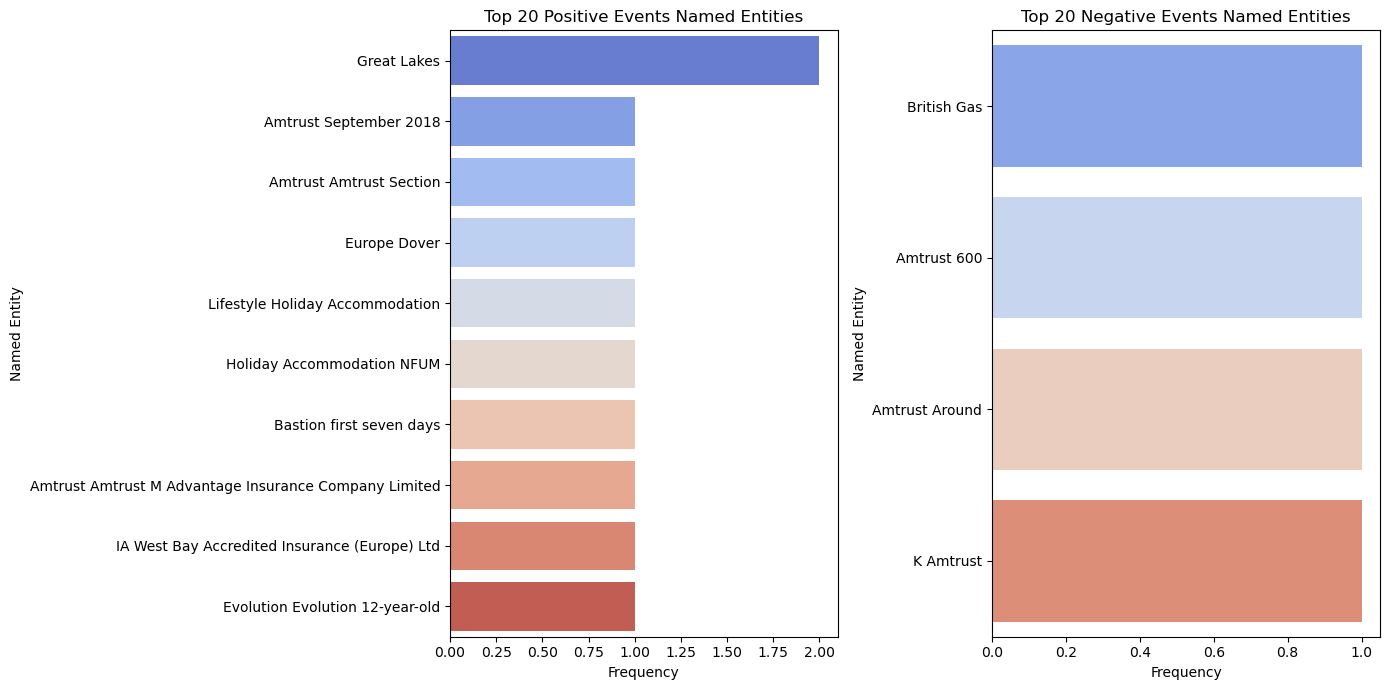

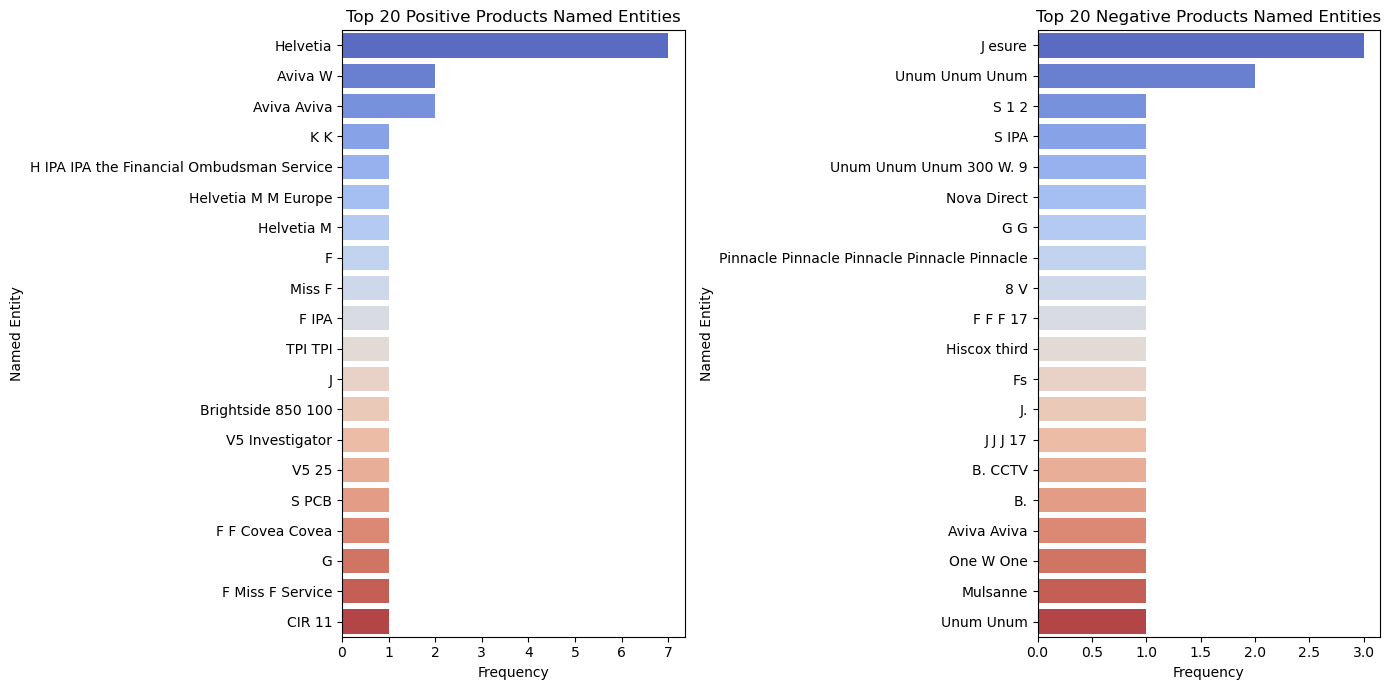

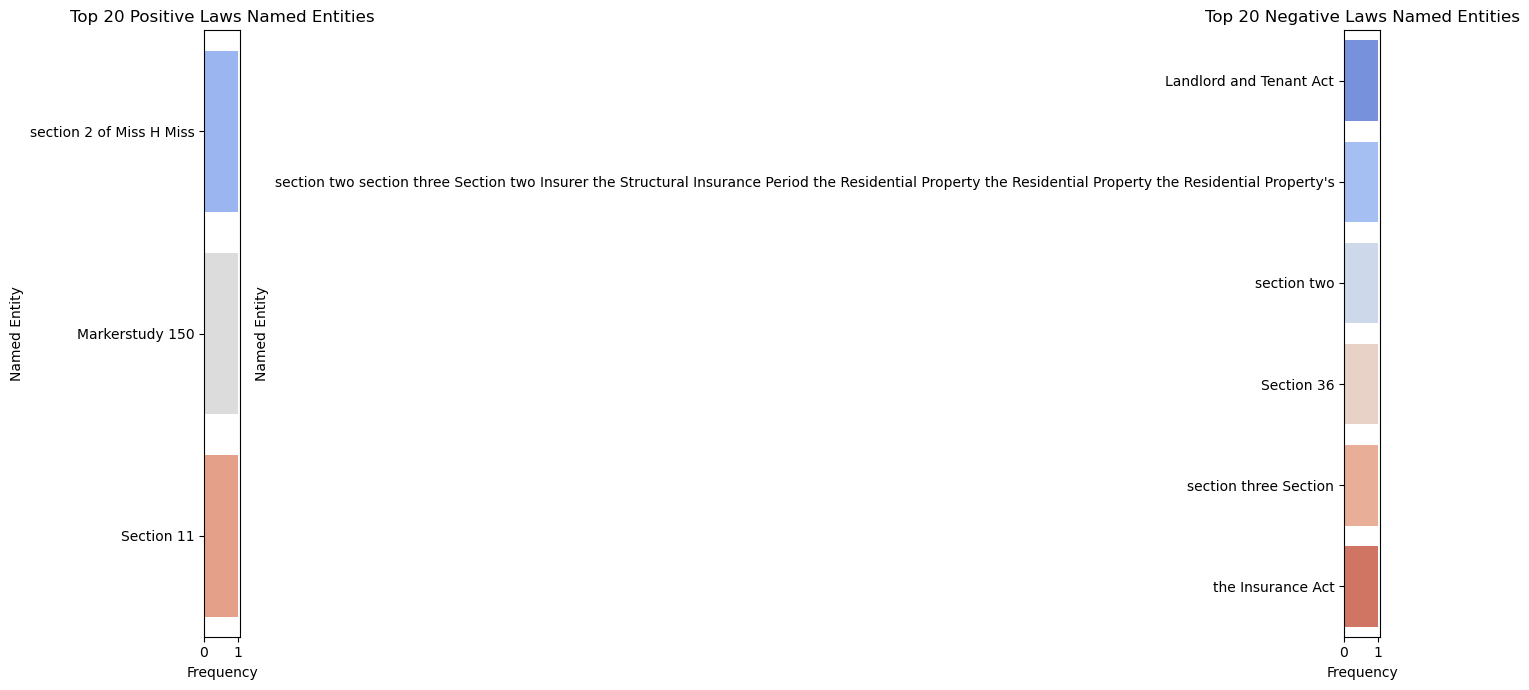

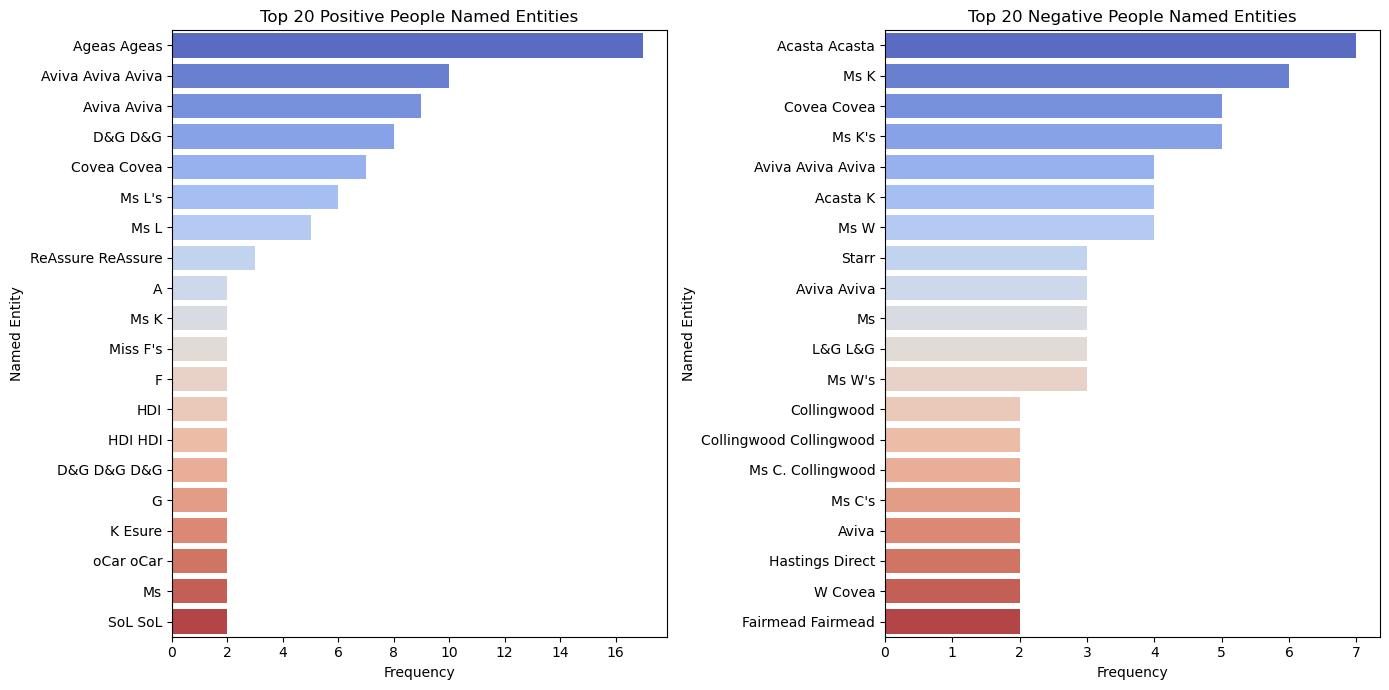

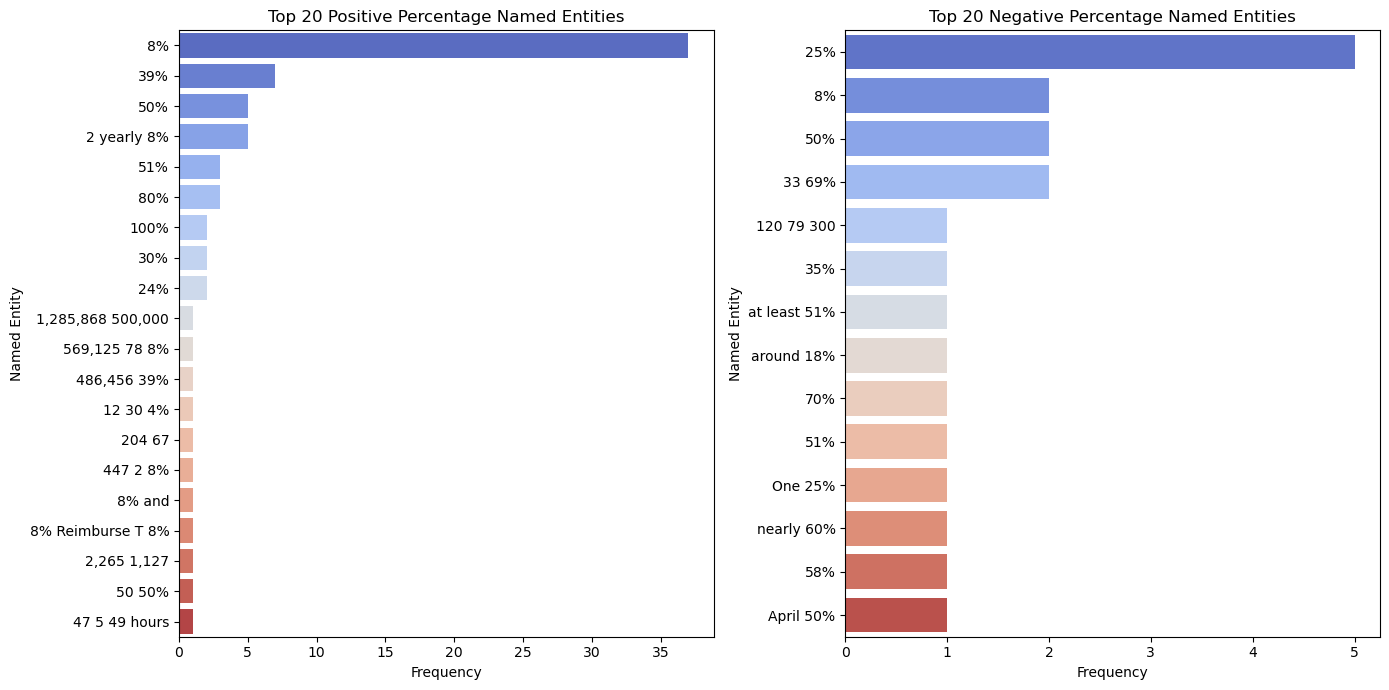

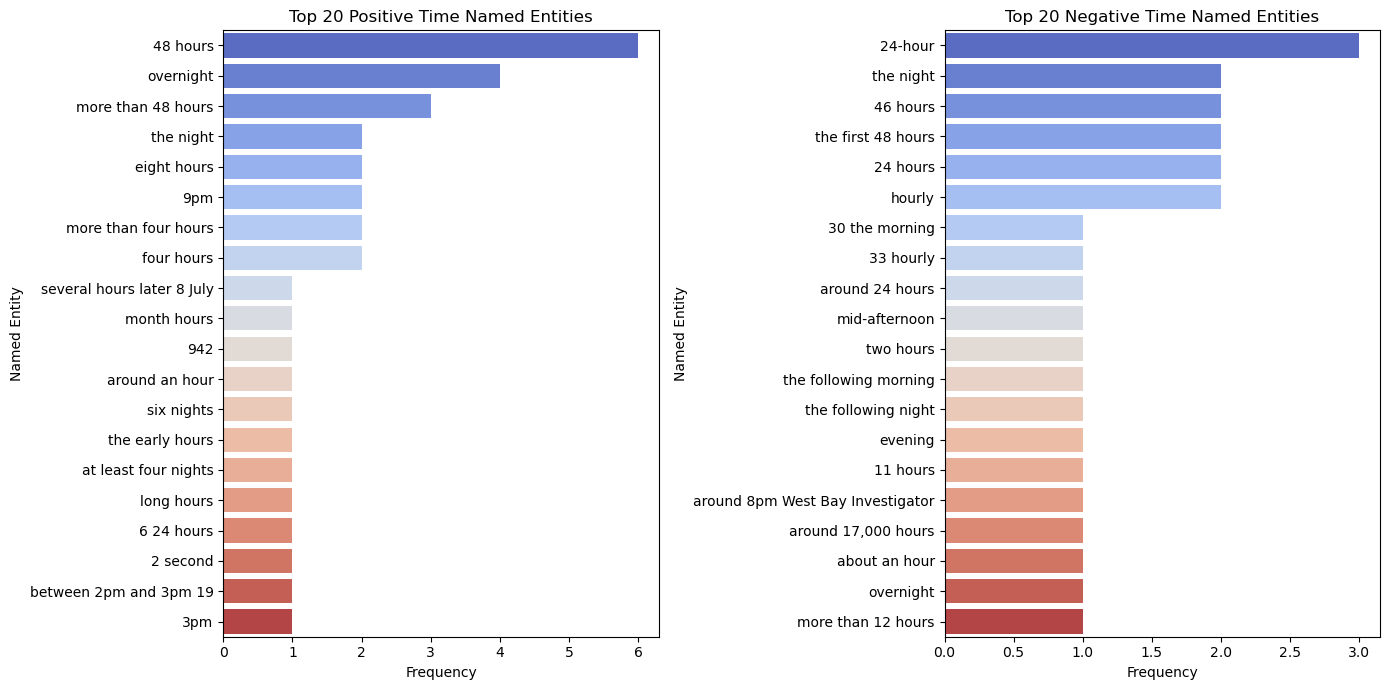

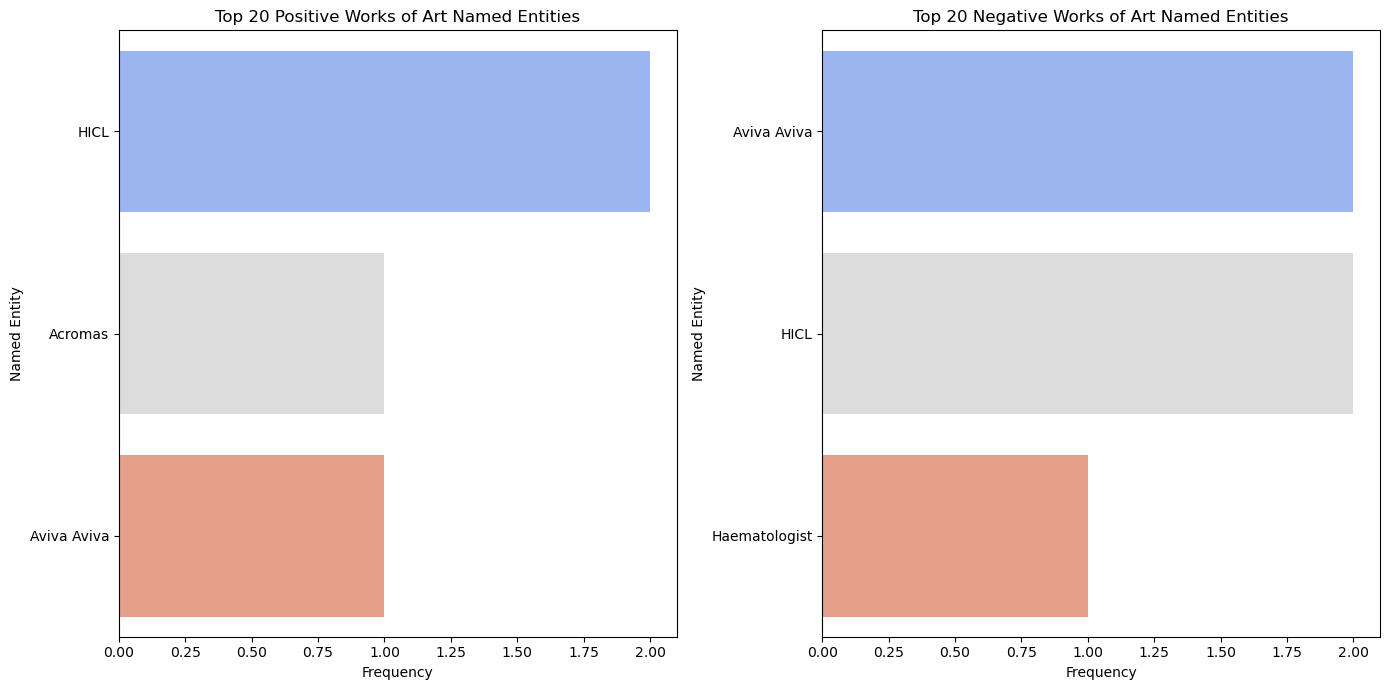

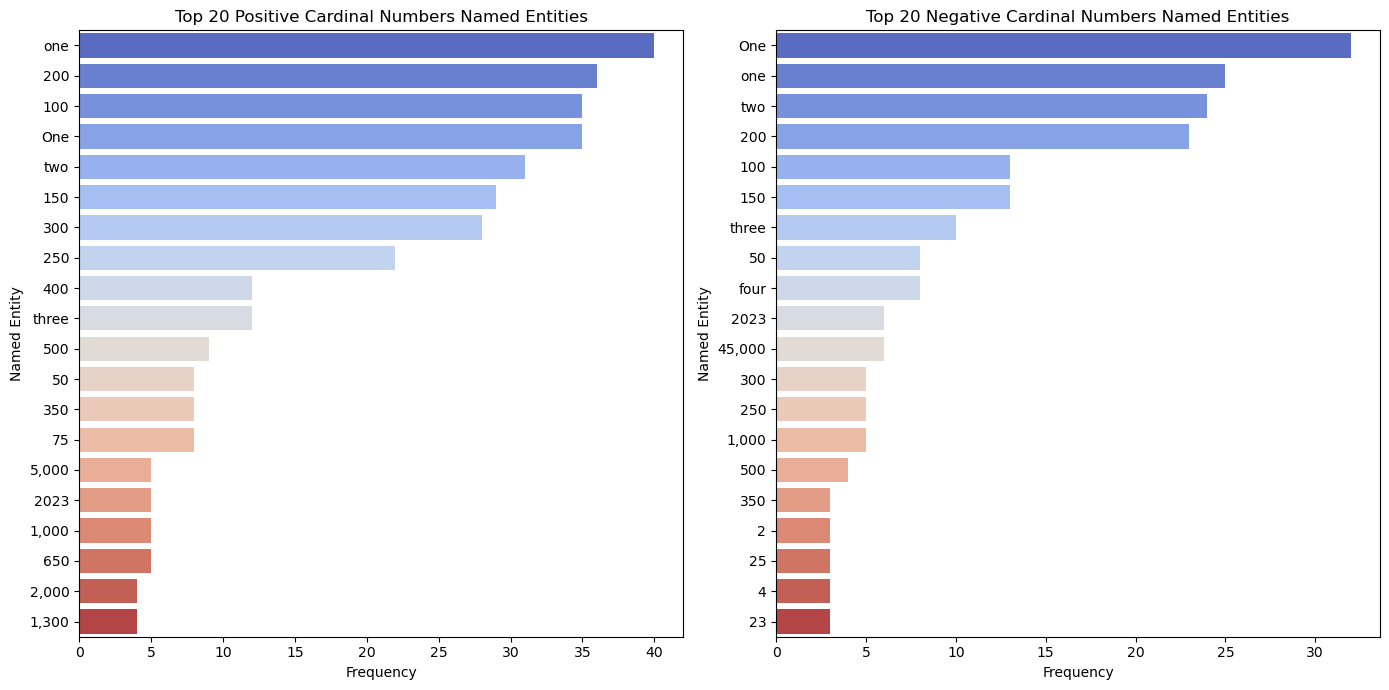

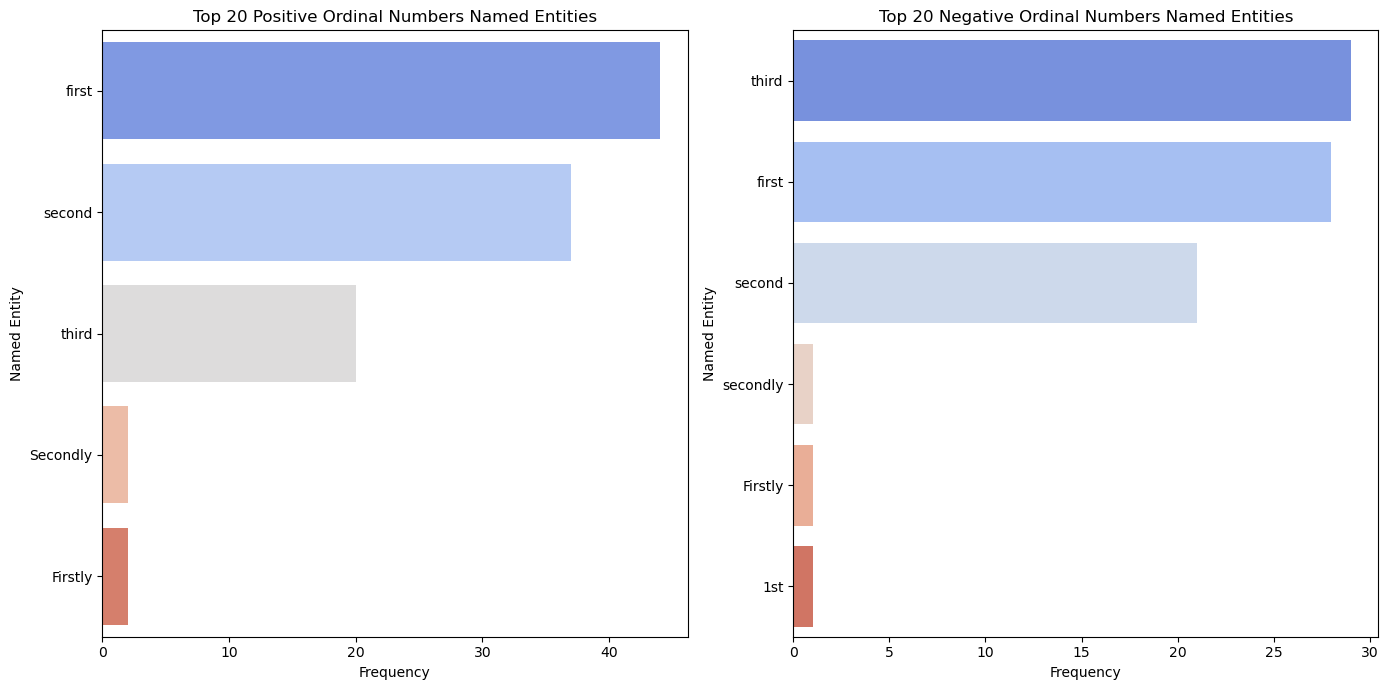

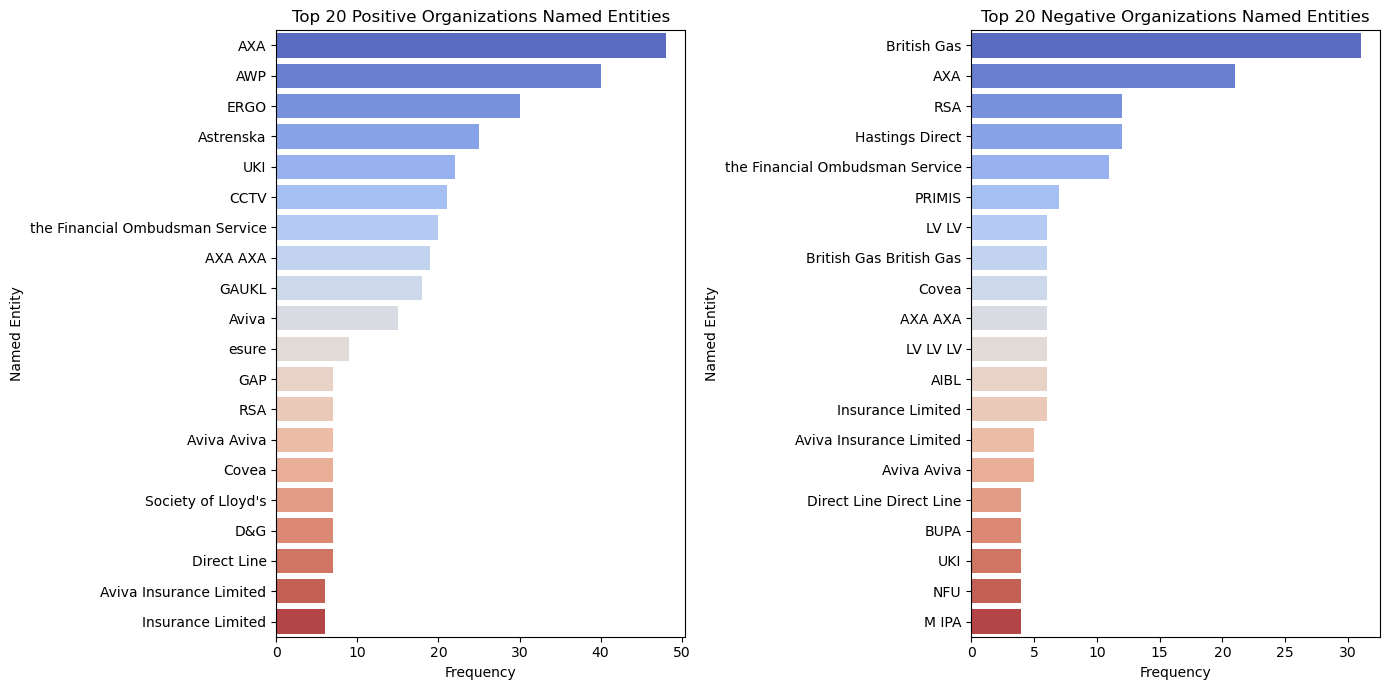

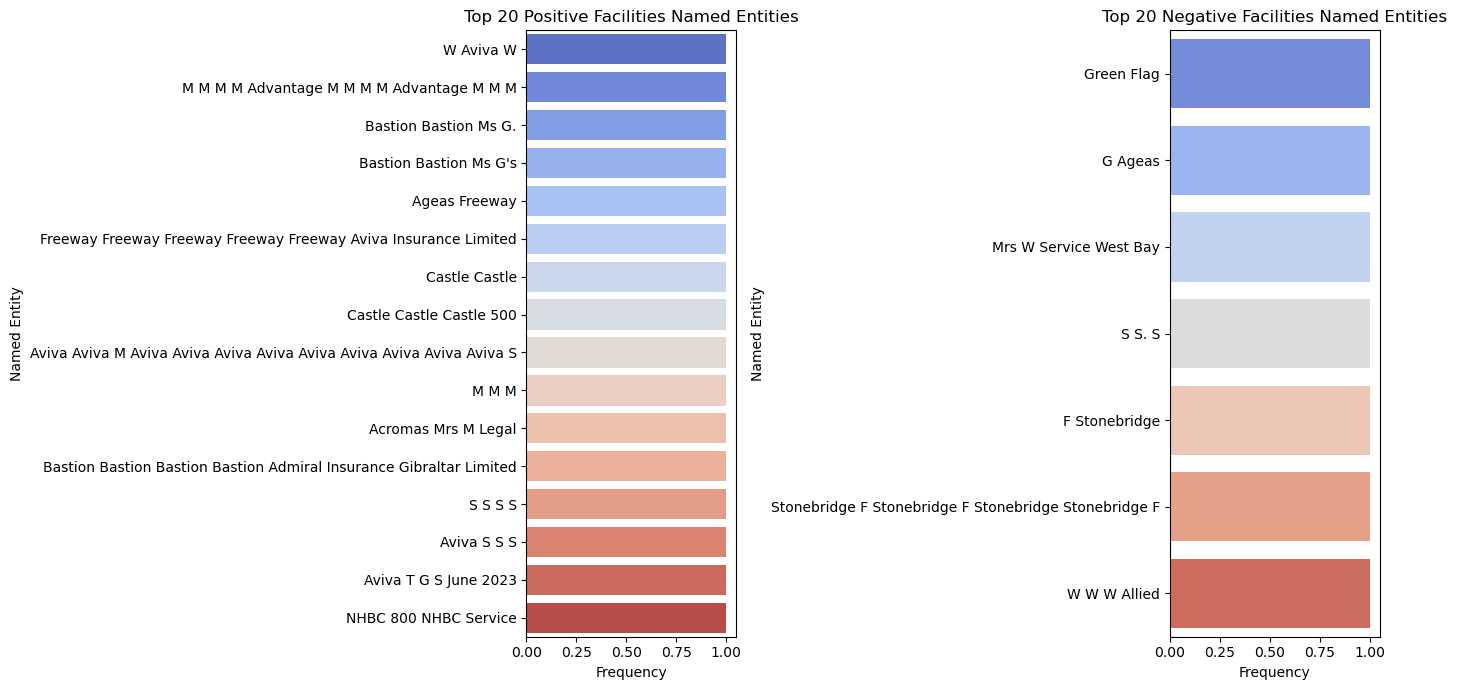

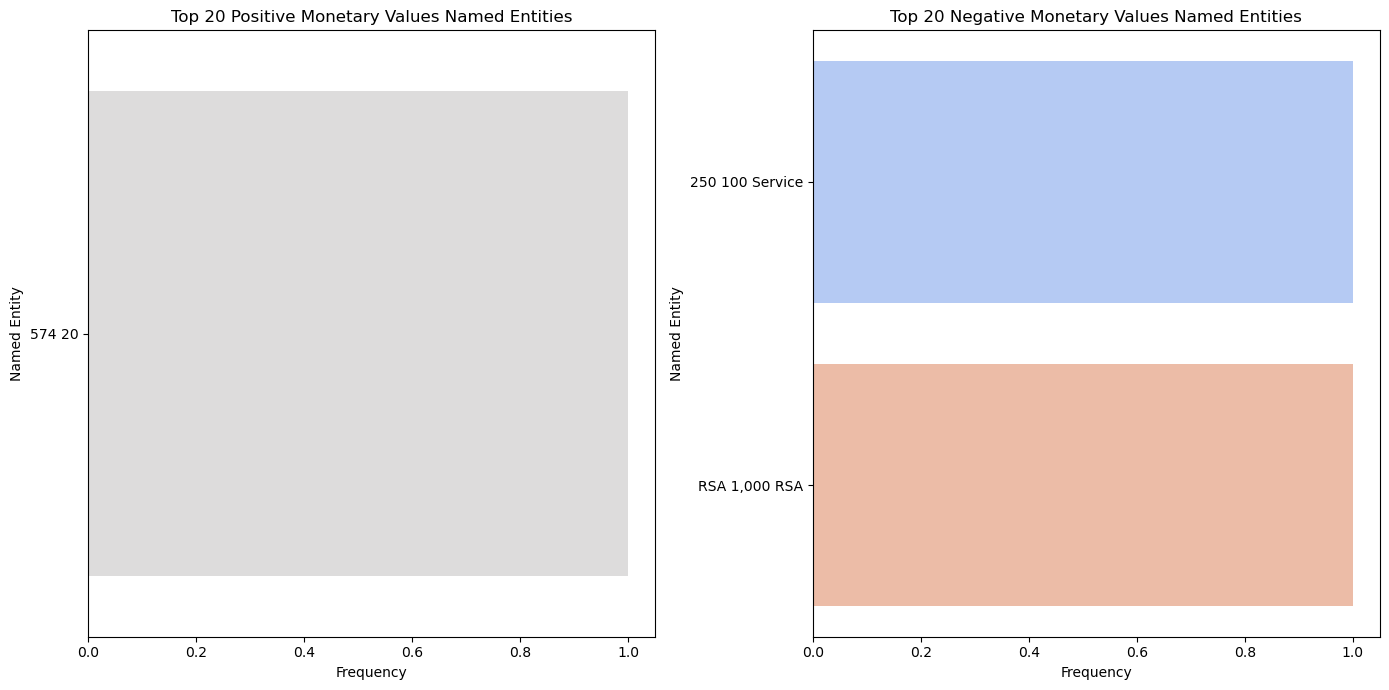

ValueError: min() arg is an empty sequence

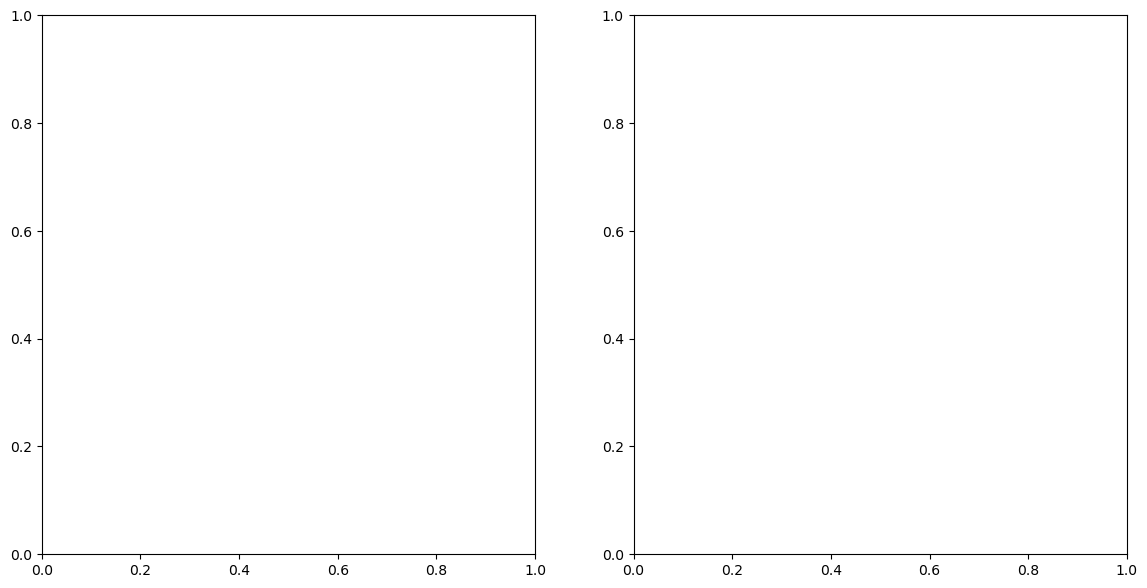

In [72]:
# plot named entities in different categories for positive and negative documents

def plot_named_entities(pos_named_entities, neg_named_entities, category, category_map):
    pos_named_entity_counts = Counter(pos_named_entities)
    pos_named_entity_df = pd.DataFrame(pos_named_entity_counts.most_common(20), columns=['Named Entity', 'Frequency'])
    neg_named_entity_counts = Counter(neg_named_entities)
    neg_named_entity_df = pd.DataFrame(neg_named_entity_counts.most_common(20), columns=['Named Entity', 'Frequency'])
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    sns.barplot(x='Frequency', y='Named Entity', data=pos_named_entity_df, ax=axs[0], palette='coolwarm')
    sns.barplot(x='Frequency', y='Named Entity', data=neg_named_entity_df, ax=axs[1], palette='coolwarm')
    # create a map of category names to more readable names
    axs[0].set_title(f'Top 20 Positive {category_map[category]} Named Entities')
    axs[1].set_title(f'Top 20 Negative {category_map[category]} Named Entities')
    plt.tight_layout()
    plt.show()


category_map = {'NORP': 'Nationalities, Religious/Political Groups',
                'LOC': 'Locations',
                'DATE': 'Dates',
                'GPE': 'Countries, Cities, States',
                'EVENT': 'Events',
                'PRODUCT': 'Products',
                'LAW': 'Laws',
                'PERSON': 'People',
                'PERCENT': 'Percentage',
                'TIME': 'Time',
                'WORK_OF_ART': 'Works of Art',
                'CARDINAL': 'Cardinal Numbers',
                'ORDINAL': 'Ordinal Numbers',
                'ORG': 'Organizations',
                'FAC': 'Facilities',
                'MONEY': 'Monetary Values',
                'LANGUAGE': 'Languages',
                'QUANTITY': 'Measurements'}

# plot named entities in different categories for positive and negative documents
for category in named_entity_categories:
    pos_named_entities_in_category = [ent.text for ent in nlp(' '.join(positive_named_entities)).ents if ent.label_ == category]
    neg_named_entities_in_category = [ent.text for ent in nlp(' '.join(negative_named_entities)).ents if ent.label_ == category]
    plot_named_entities(pos_named_entities_in_category, neg_named_entities_in_category, category, category_map)